К текущему моменту мы научились обучать простейшую линейную регрессию: причем научились пользоваться как готовыми методами из sklearn, так и реализовывать поиск решения оптимальных коэффициентов самостоятельно с помощью градиентного спуска.

На последних занятиях мы узнали, что на практике часто приходится прибегать к некоторым хитростям, чтобы оценить, действительно ли модель отлично справляется со своей главной задачей - делать хорошие предсказания на новых данных в будущем, или, как еще говорят, в проде - после запуска.

Для этого было введено понятие так называемой обобщающей способности модели. Оно помогает нам оценить, насколько наша модель подогналась под увиденные данные и насколько она окажется хороша на новых данных.

Обобщающую способность мы научились оценивать с помощью метода Кросс-Валидации.



Построим для старой задачи с предсказанием длительности поездки в такси 2 модели линейной регрессии. Для каждой из них замерим качество на кросс-валидации и на тесте, заранее его отложив.

Считается, что если для K-Fold Кросс-Валидации брать большие значения K (то есть большое количество сплитов для разбиения тренировочной выборки на тренировку-валидацию), то оценка среднеквадратической ошибки будет получаться более справедливой. Так, например, когда K оказывается максимальным, а именно равным количеству объектов в выборке (каждый раз в валидации у нас 1 новый объект), то такой метод Кросс-Валидации еще называют LeaveOneOut.

Главная причина, почему мало где его используют, состоит в дороговизне такого метода. Например, в данной задаче в TAXI_train.csv лежит почти 1,2 млн. объектов. Тогда, чтобы замерить качество на LeaveOneOut валидации, нам пришлось бы обучить 1,2 млн. различных версий одной модели, что, конечно, не вписыватеся в рамки адекватного времени и прочих ресурсов.

Поэтому выберем компромиссное значение в виде 20 фолдов для K-Fold Кросс-Валидации.

Внимание! Для каждой из 2 моделей очевидно было бы справедливым замерять качество на тех же самых объектах, поэтому сплиты лучше зафиксировать сразу.

P.S. Оптимизировать будем MSLE метрику. И сравнивать модели тоже будем по ней будем. Как из домашнего задания про метрики, только без корня! :)

$$ \frac{1}{\ell} $$


### Модель №1 Для начала посчитаем ошибку на Кросс-Валидации и Тесте для нашей самой базовой модели до вычленения каких-либо признаков, а просто взяв все вещественные колонки.

In [1]:
import pandas as pd

ссылка на <a href='https://yadi.sk/d/pq27hHNHsR_1rA'>датасет</a>

In [3]:
initial_data = pd.read_csv('initial_data.csv', index_col='id')

In [4]:
initial_data.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455.0
id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663.0
id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124.0
id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429.0
id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435.0


In [11]:
initial_data = initial_data.select_dtypes(include=['int', 'float'])

### ТрюК!

In [12]:
### Замерять будем MSLE. Можно показать, что для оптимизации MSLE,
### Достаточно логарифмировать таргетную переменную, а потом оптимизировать привычные MSE
import numpy as np

initial_data = initial_data.assign(log_trip_duration=np.log1p(initial_data['trip_duration']))
initial_data = initial_data.drop('trip_duration', axis=1)

### Объяснение:

Пусть имеем модель $a(x)$, обученную на MSE от $y$:
$$
\text{MSE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(y_i - a(x_i)\big)^2 \rightarrow min
$$

Также представим модель $a^*(x)$, обученную на MSE от $\log{(y + 1)}$:
$$
\text{MSE}(X, \log{(y+1)}, a^*) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - a^*(x_i)\big)^2 \rightarrow min
$$

Так как вторая модель старается аппроксимироваться ответы в виде $a^*(x) \approx \log{(y+1)}$, то для того, чтобы получить изначальные таргеты, необходимо выходы $a^*(x)$ проэкспоненцировать в виде следующего отношения: $a(x) = e^{a^*(x)} - 1$, то есть $a^*(x) = \log{(a(x) + 1)}$, где $a^*(x)$ дает логарифмические выходы, а $a(x)$ - изначальные. Подставим данное соотношение в MSE выше, получим:

$$
\text{MSE}(X, \log{(y+1)}, \log{(a(x) + 1)}) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2 \rightarrow min
$$

А это в точности MSLE от $y$:

$$
\text{MSLE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2 \rightarrow min
$$

In [47]:
### Выделим test
from sklearn.model_selection import train_test_split

X = initial_data.drop('log_trip_duration', axis=1)
y = initial_data['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [60]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.linear_model import LinearRegression

In [36]:
### Применим K-Fold на оставшуюяся валидационную часть X_train, y_train
from sklearn.model_selection import KFold

splitter = KFold(n_splits=20, shuffle=True, random_state=33)

In [64]:
### Замерьте качество на кросс-валидации!
train_er = []
test_er = []
for train_index, test_index in splitter.split(X_train):
    x_tr, y_tr = X_train.values[train_index], y_train.values[train_index]
    x_tst, y_tst = X_train.values[test_index], y_train.values[test_index]
    
    lin_model = LinearRegression()
    lin_model.fit(x_tr, y_tr)
    train_er.append(mean_squared_error(y_tr, lin_model.predict(x_tr)))
    test_er.append(mean_squared_error(y_tst, lin_model.predict(x_tst)))
    
    

In [65]:
import matplotlib.pyplot as plt

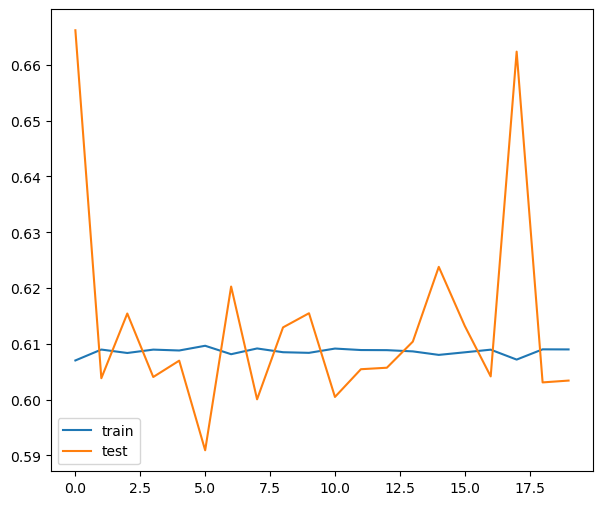

In [68]:
fig = plt.figure()
fig.set_size_inches(7, 6)

plt.plot(train_er,  label='train')
plt.plot(test_er, label='test')

plt.legend();

In [70]:
np.mean(test_er)

0.6134219105328514

In [71]:
### Теперь построим модель на всей тренировочной выборке
### и замерим качество на тесте!
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [73]:
mean_squared_error(y_test, lin_model.predict(X_test.values))

0.6060227205373284

In [ ]:
### Укажите в ответе на задание 4 среднее качество моделей на валидационных выборках
### и качество модели, обученной на полной тренировочной выборке, на тестовой выборке.
### В качестве разделителя используйте точку, ответ округлите до тысячных.

### Модель №2. Проделаем все то же самое, только для модели с более осознанными признаками, которые удалось получить ранее

In [75]:
processed_data = pd.read_csv('processed_data.csv', index_col='id')

In [76]:
processed_data.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,distance_km
id,,,,,
id2875421,1,930.399753,0,455.0,1.500479
id2377394,0,930.399753,0,663.0,1.807119
id3858529,1,930.399753,0,2124.0,6.392080
id3504673,1,930.399753,0,429.0,1.487155
id2181028,1,930.399753,0,435.0,1.189925


In [77]:
### Замерять будем MSLE. Можно показать, что для оптимизации MSLE,
### Достаточно логарифмировать таргетную переменную, 
### а потом оптимизировать привычные MSE
import numpy as np

processed_data = processed_data.assign(log_trip_duration=np.log1p(processed_data['trip_duration']))
processed_data = processed_data.drop('trip_duration', axis=1)

In [78]:
X_2 = processed_data.drop('log_trip_duration', axis=1)
y_2 = processed_data['log_trip_duration']

In [88]:
### Важно! Когда сравниваем модели по их качеству
### на валидации и на тесте, не шаффлим данные заново!

test_indexes = X_test.index
train_indexes = X_train.index

X_train_2 = X_2[X_2.index.isin(train_indexes)]
y_train_2 = y_2[y_2.index.isin(train_indexes)]

X_test_2 = X_2[X_2.index.isin(test_indexes)]
y_test_2 = y_2[y_2.index.isin(test_indexes)]

In [89]:
### Замерьте качество на кросс-валидации!
train_er2 = []
test_er2 = []
for train_index, test_index in splitter.split(X_train_2):
    x_tr, y_tr = X_train_2.values[train_index], y_train_2.values[train_index]
    x_tst, y_tst = X_train_2.values[test_index], y_train_2.values[test_index]
    
    lin_model = LinearRegression()
    lin_model.fit(x_tr, y_tr)
    train_er2.append(mean_squared_error(y_tr, lin_model.predict(x_tr)))
    test_er2.append(mean_squared_error(y_tst, lin_model.predict(x_tst)))

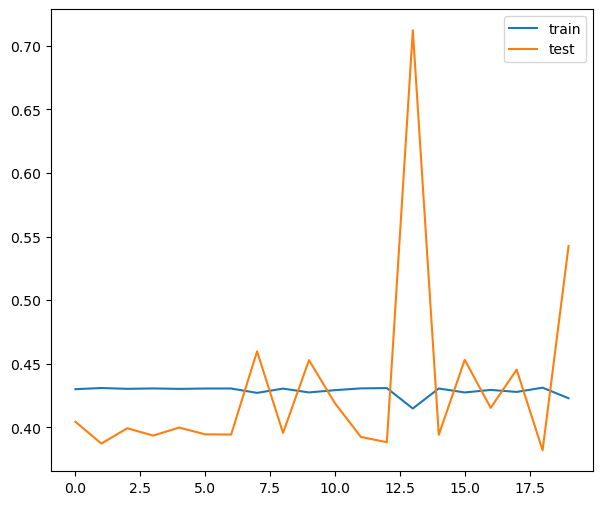

In [90]:
fig = plt.figure()
fig.set_size_inches(7, 6)

plt.plot(train_er2,  label='train')
plt.plot(test_er2, label='test')

plt.legend();

In [91]:
np.mean(test_er2)

0.43132577042329423

In [92]:
### Теперь построим модель и замерим качество на тесте!
lin_model2 = LinearRegression()
lin_model.fit(X_2, y_2)

LinearRegression()

In [93]:
mean_squared_error(y_test_2, lin_model.predict(X_test_2))

0.4065994747846105

In [ ]:
### Укажите в ответе на задание 5 среднее качество моделей на валидационных выборках
### и качество модели, обученной на полной тренировочной выборке, на тестовой выборке.
### В качестве разделителя используйте точку, ответ округлите до тысячных.

### Какую модель среди двух стоило бы выбрать? Помогла ли нам базовая обработка признаков с первых уроков? 